In [1]:
import pandas as pd
import numpy as np
import os
os.chdir(r"D:\Jupyter CS 273A\Project\data")

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from scipy.sparse import hstack,csr_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [3]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [4]:
train = pd.read_csv('train.csv').fillna(' ')
test = pd.read_csv('test.csv').fillna(' ')
train,val=train_test_split(train,test_size=0.25)


In [44]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
91301,f4296baefb85dbee,"""\n\nThat page strongly supports my case. Fir...",0,0,0,0,0,0
96984,06e2cc123093c316,I left a response at User talk:Cptnono. — Tal...,0,0,0,0,0,0
72230,c15ea6b164ca89cb,Wikipedia talk:Talk page guidelines\nThank you...,0,0,0,0,0,0
135599,d52fc1379595c420,"Well, those (disambiguation) pages are just go...",0,0,0,0,0,0
152942,950cc1e39d9e4b2d,Good a.m. - I did leave a note with the tea po...,0,0,0,0,0,0


In [7]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [5]:
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

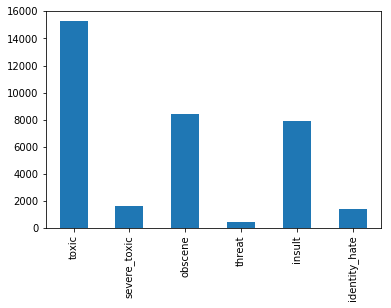

In [25]:
trainplot=pd.read_csv('train.csv').fillna(' ')
trainplot["sum1"]=trainplot["toxic"]+trainplot["severe_toxic"]+trainplot["obscene"]+trainplot["threat"]+\
trainplot["insult"]+trainplot["identity_hate"]
trainplot=trainplot[trainplot.sum1!=0]
del trainplot["sum1"]
trainplot[['toxic','severe_toxic','obscene','threat','insult','identity_hate']].sum().plot.bar()
plt.show()

In [6]:
train_text = train['comment_text']
validation_text = val['comment_text']

test_text = test['comment_text']

all_text = pd.concat([train_text, test_text,validation_text])

In [7]:
word_vectorizer = TfidfVectorizer(sublinear_tf=True,strip_accents='unicode',analyzer='word',token_pattern=r'\w{1,}',\
                                  stop_words='english',ngram_range=(1,3),max_features=20000)
word_vectorizer.fit(all_text)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=20000, min_df=1,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents='unicode', sublinear_tf=True,
        token_pattern='\\w{1,}', tokenizer=None, use_idf=True,
        vocabulary=None)

In [8]:
train_features = word_vectorizer.transform(train_text)
test_features = word_vectorizer.transform(test_text)
val_features = word_vectorizer.transform(validation_text)

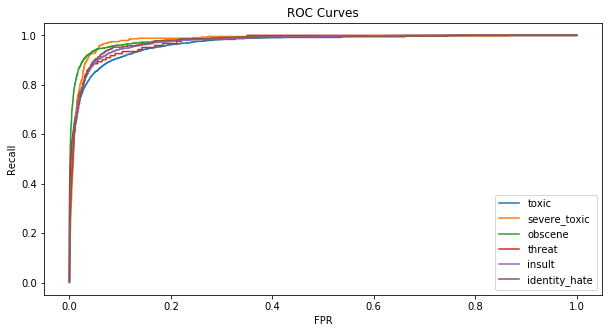

Validation AUC = 0.976765241852969


In [9]:
scores = []
test_pred = pd.DataFrame.from_dict({'id': test['id']})
train_pred= pd.DataFrame.from_dict({'id': train['id']})
val_pred= pd.DataFrame.from_dict({'id': val['id']})
aucs=[]
plt.figure(figsize=(10,5))

for class_name in class_names:
    #print("Training class: "+class_name)
    train_target = train[class_name]
    classifier = LogisticRegression()
    
    classifier.fit(train_features, train_target)
    #train_pred[class_name]=classifier.predict_proba(train_features)[:, 1]
    val_pred[class_name]=classifier.predict_proba(val_features)[:, 1]
    test_pred[class_name]=classifier.predict_proba(test_features)[:, 1]


    false_positive_rate, recall, thresholds = roc_curve(val[class_name],val_pred[class_name])
    roc_auc = auc(false_positive_rate, recall)
    #print(roc_auc)
    aucs.append(roc_auc)

    plt.plot(false_positive_rate, recall, label='AUC = %0.2f' %roc_auc)
    
plt.title("ROC Curves")
plt.xlabel("FPR")
plt.ylabel("Recall")
plt.legend(class_names,loc="lower right")
plt.show()

print("Validation AUC = "+str(np.mean(aucs)))

In [10]:
test_pred.to_csv('submission_logisticreg.csv', index=False)